In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [2]:
oil_df = pd.read_csv("./store-sales-time-series-forecasting/oil.csv")
oil_df["date"] = pd.to_datetime(oil_df["date"], format="%Y-%m-%d")

In [3]:
oil_df.head().style.set_properties(subset=['date'], **{'background-color':'salmon'})

,date,dcoilwtico
0,2013-01-01 00:00:00,nan
1,2013-01-02 00:00:00,93.140000
2,2013-01-03 00:00:00,92.970000
3,2013-01-04 00:00:00,93.120000
4,2013-01-07 00:00:00,93.200000


In [4]:
oil_df.isna().value_counts()

date   dcoilwtico
False  False         1175
       True            43
dtype: int64

In [5]:
start_date = oil_df['date'].min()
end_date = oil_df['date'].max()
date_range = pd.date_range(start=start_date, end=end_date, freq = '7D')
missing_dates = date_range.difference(oil_df.date.unique())
missing_dates

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [6]:
print(len(missing_dates))

0


In [7]:
pd.date_range(start=start_date, end=end_date, freq = '7D')

DatetimeIndex(['2013-01-01', '2013-01-08', '2013-01-15', '2013-01-22',
               '2013-01-29', '2013-02-05', '2013-02-12', '2013-02-19',
               '2013-02-26', '2013-03-05',
               ...
               '2017-06-27', '2017-07-04', '2017-07-11', '2017-07-18',
               '2017-07-25', '2017-08-01', '2017-08-08', '2017-08-15',
               '2017-08-22', '2017-08-29'],
              dtype='datetime64[ns]', length=244, freq='7D')

In [8]:
def weekly_oil_prices(df, col_price):
    
    new_rows = []
    start_date = df.date.min()
    end_date = df.date.max()
    week_dates = pd.date_range(start=start_date, end=end_date, freq='7D')
    for i in range(len(week_dates)-1):
        date_1 = week_dates[i]
        date_2 = week_dates[i+1]
        mean_oil_prices = df[col_price].where((df['date'] >= date_1) & (df['date'] < date_2)).mean()
        new_row = {
            "date": date_1,
            col_price: mean_oil_prices
        }
        new_rows.append(new_row)
    df = pd.DataFrame(new_rows)
    return df
        

In [9]:
train_data = weekly_oil_prices(oil_df, 'dcoilwtico')

In [10]:
train_data.head()

,date,dcoilwtico
0,2013-01-01,93.1075
1,2013-01-08,93.5940
2,2013-01-15,94.6600
3,2013-01-22,95.5200
4,2013-01-29,97.3840


In [11]:
def insert_missing_dates(df, missing_dates):
    new_rows = []
    for date in missing_dates:
        new_row = {
            "date": date,
            "dcoilwtico": np.nan
        }
        new_rows.append(new_row)
    new_data = pd.DataFrame(new_rows)
    df = pd.concat([df, new_data], ignore_index = True)
    return df

In [12]:
#train_data = insert_missing_dates(oil_df, missing_dates)

In [13]:
#train_data.dcoilwtico = train_data.dcoilwtico.interpolate()

In [14]:
#train_data.isna().value_counts()

In [15]:
#train_data.dropna()

In [16]:
train_data.isna().value_counts()

date   dcoilwtico
False  False         243
dtype: int64

In [17]:
train_data = train_data.sort_values(by='date')
train_data['intervals'] = train_data.date - train_data.date.shift(1)
train_data['intervals'].value_counts()

7 days    242
Name: intervals, dtype: int64

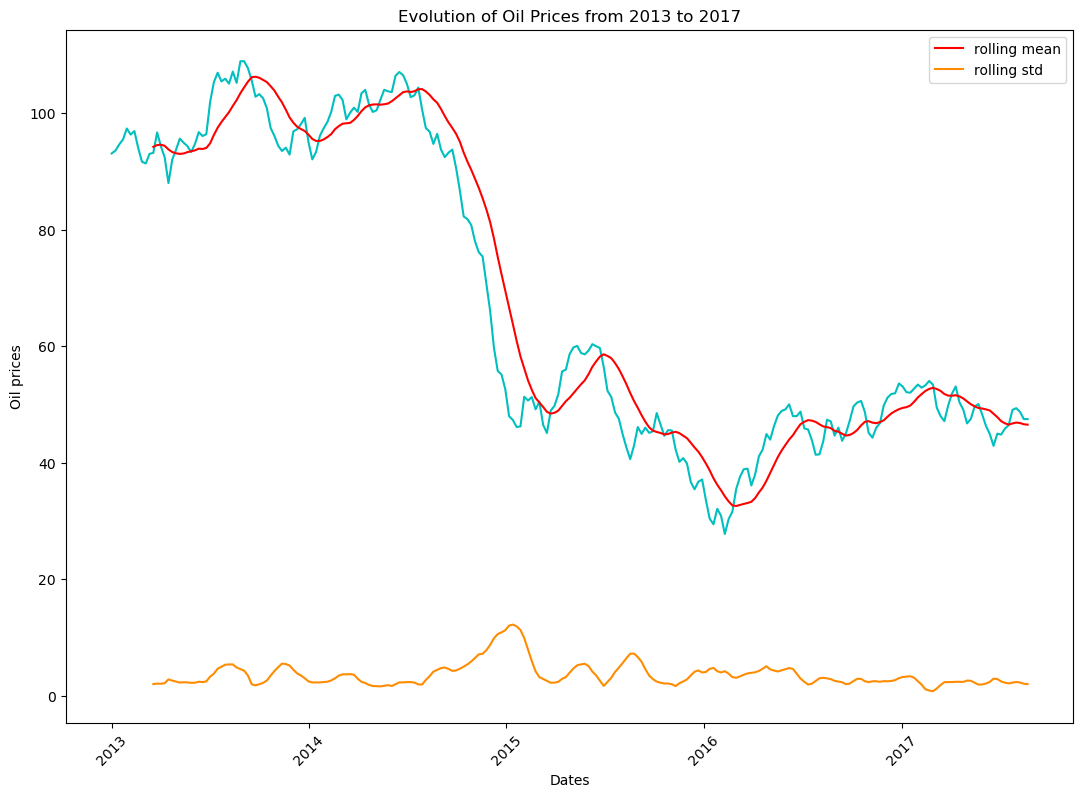

In [18]:
fig, ax = plt.subplots(nrows = 1, ncols=1, figsize=(13,9))

rolmean=train_data.dcoilwtico.rolling(window=12).mean()
rolstd=train_data.dcoilwtico.rolling(window=12).std()

sns.lineplot(x=train_data.date, y=train_data.dcoilwtico, ax=ax, color='c')
sns.lineplot(x=train_data.date, y=rolmean, ax=ax, color='red', label='rolling mean')
sns.lineplot(x=train_data.date, y=rolstd, ax=ax, color='darkorange', label='rolling std')

ax.set_title('Evolution of Oil Prices from 2013 to 2017')
ax.set_ylabel('Oil prices')
ax.set_xlabel('Dates')
plt.xticks(rotation=45)
plt.show()

In [19]:
def adfuller_test(df):
    
    adtest = adfuller(df['dcoilwtico'])
    print('Dickey-Fuller Test Results: \n')
    statistics = ['Test Statistic','p-value','Lags Used','No. of Observations', 'Critical Values']
    for i, stat in enumerate(statistics):
        print(stat + ': '+str(adtest[i]))

In [20]:
train_data.dropna(inplace = True)
train_data.isna().sum()

date          0
dcoilwtico    0
intervals     0
dtype: int64

In [21]:
adfuller_test(train_data)

Dickey-Fuller Test Results: 

Test Statistic: -1.0293535334162458
p-value: 0.7424083146156034
Lags Used: 1
No. of Observations: 240
Critical Values: {'1%': -3.4578942529658563, '5%': -2.8736593200231484, '10%': -2.573228767361111}


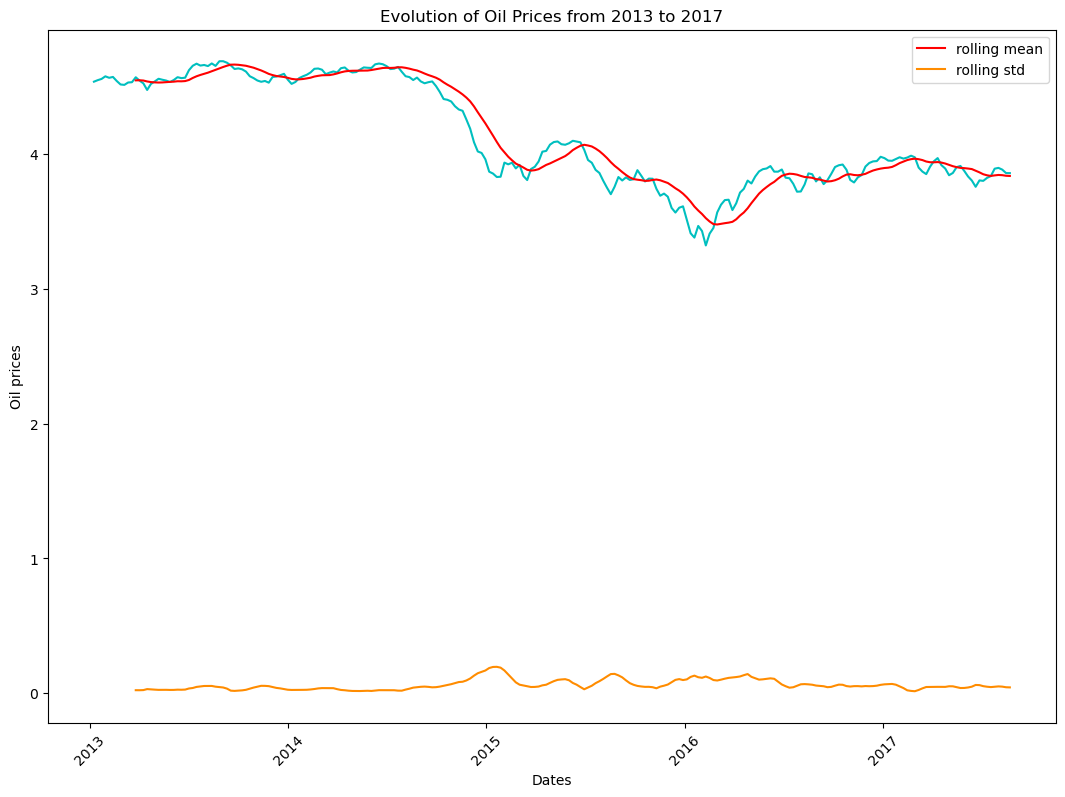

In [22]:
#We must convert this time series to a stationary one by: Log transformation OR Differencing

fig, ax = plt.subplots(nrows = 1, ncols=1, figsize=(13,9))

rolmean=np.log(train_data.dcoilwtico).rolling(window=12).mean()
rolstd=np.log(train_data.dcoilwtico).rolling(window=12).std()

sns.lineplot(x=train_data.date, y=np.log(train_data.dcoilwtico), ax=ax, color='c')
sns.lineplot(x=train_data.date, y=rolmean, ax=ax, color='red', label='rolling mean')
sns.lineplot(x=train_data.date, y=rolstd, ax=ax, color='darkorange', label='rolling std')

ax.set_title('Evolution of Oil Prices from 2013 to 2017')
ax.set_ylabel('Oil prices')
ax.set_xlabel('Dates')
plt.xticks(rotation=45)
plt.show()

We still have some upward and downward trends, hence the data is non-stationary even after the log transformation

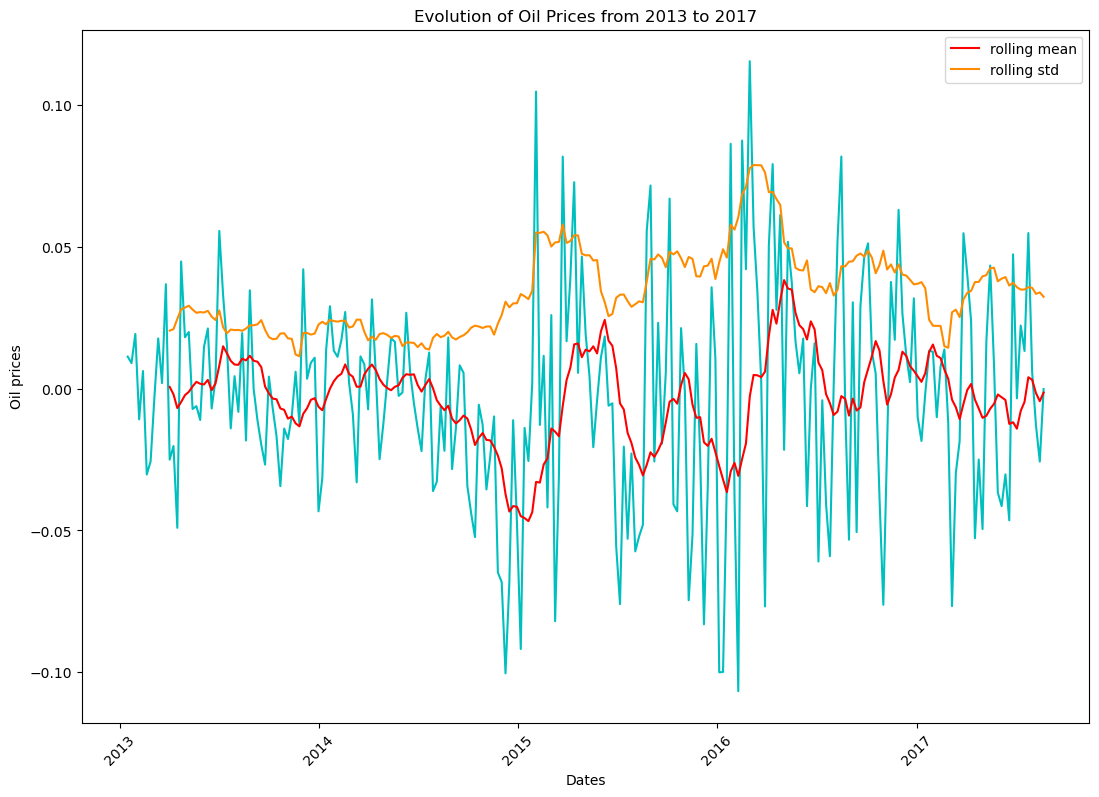

In [23]:
fig, ax = plt.subplots(nrows = 1, ncols=1, figsize=(13,9))

df_shift = np.log(train_data.dcoilwtico) - np.log(train_data.dcoilwtico).shift(periods = 1)
rolmean_diff=df_shift.rolling(window=12).mean()
rolstd_diff=df_shift.rolling(window=12).std()

sns.lineplot(x=train_data.date, y=df_shift, ax=ax, color='c')
sns.lineplot(x=train_data.date, y=rolmean_diff, ax=ax, color='red', label='rolling mean')
sns.lineplot(x=train_data.date, y=rolstd_diff, ax=ax, color='darkorange', label='rolling std')

ax.set_title('Evolution of Oil Prices from 2013 to 2017')
ax.set_ylabel('Oil prices')
ax.set_xlabel('Dates')
plt.xticks(rotation=45)
plt.show()

In [24]:
train_shifted = train_data.copy()
train_shifted.dcoilwtico = df_shift
train_shifted.dropna(inplace=True)
adfuller_test(train_shifted)

Dickey-Fuller Test Results: 

Test Statistic: -11.482796772194614
p-value: 4.947531046299353e-21
Lags Used: 0
No. of Observations: 240
Critical Values: {'1%': -3.4578942529658563, '5%': -2.8736593200231484, '10%': -2.573228767361111}


In [25]:
train_data.set_index('date', inplace = True)
train_data = train_data['dcoilwtico']
train_data.head()

date
2013-01-08    93.594
2013-01-15    94.660
2013-01-22    95.520
2013-01-29    97.384
2013-02-05    96.336
Name: dcoilwtico, dtype: float64

In [26]:
train_shifted.head()

,date,dcoilwtico,intervals
2,2013-01-15,0.011325,7 days
3,2013-01-22,0.009044,7 days
4,2013-01-29,0.019326,7 days
5,2013-02-05,-0.010820,7 days
6,2013-02-12,0.006250,7 days


In [27]:
train_shifted.set_index('date', inplace = True)
train_shifted = train_shifted['dcoilwtico']

In [28]:
train_data

date
2013-01-08    93.594
2013-01-15    94.660
2013-01-22    95.520
2013-01-29    97.384
2013-02-05    96.336
               ...  
2017-07-25    49.066
2017-08-01    49.352
2017-08-08    48.720
2017-08-15    47.484
2017-08-22    47.478
Name: dcoilwtico, Length: 242, dtype: float64

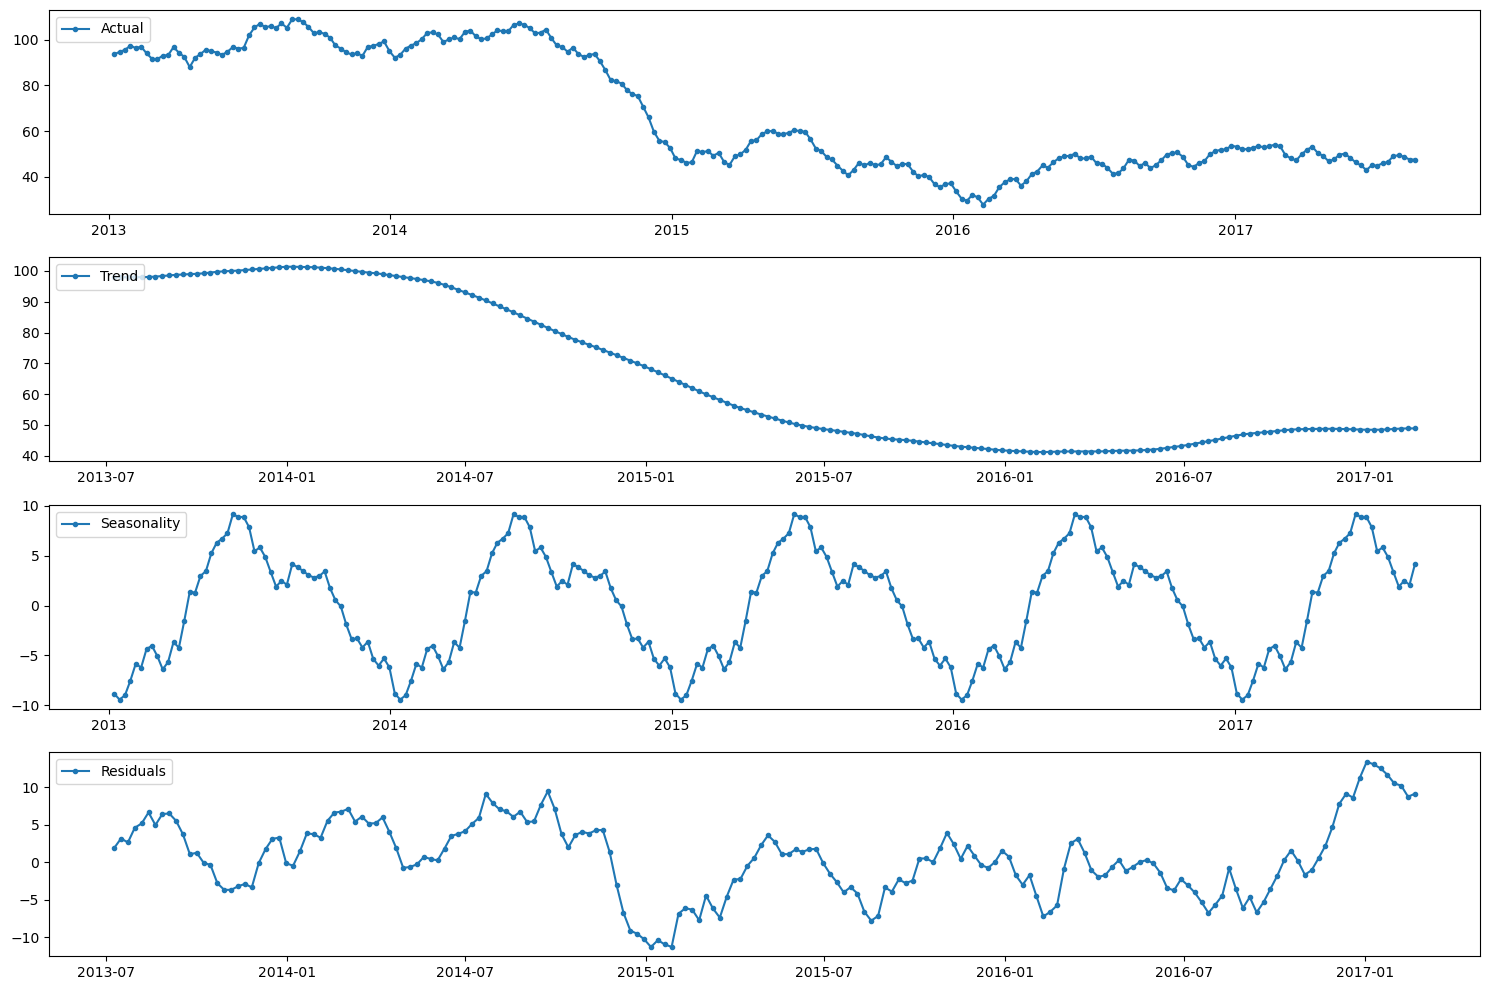

In [29]:
decomp = seasonal_decompose(train_data)
trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid
plt.figure(figsize=(15,10))
plt.subplot(411)
plt.plot(train_data, label='Actual', marker='.')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', marker='.')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality', marker='.')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals', marker='.')
plt.legend(loc='upper left')
plt.tight_layout()

<Figure size 1600x800 with 0 Axes>

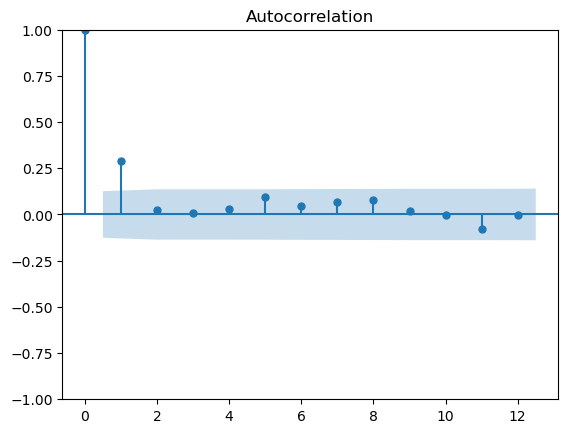

/Users/meriamchoummikh/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


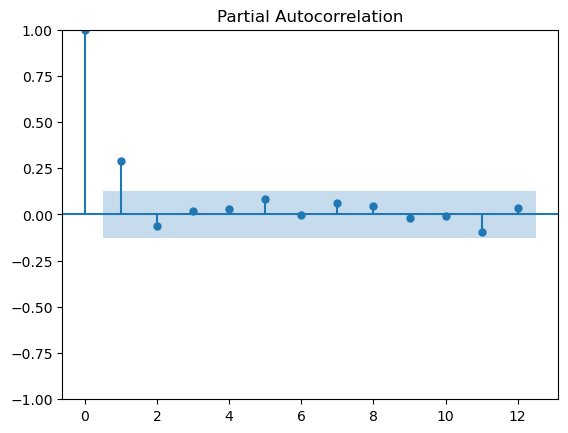

In [30]:
plt.figure(figsize = (16,8))
plot_acf(train_shifted, lags = 12) 
plt.show() 
plot_pacf(train_shifted, lags = 12) 
plt.show()

/Users/meriamchoummikh/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)


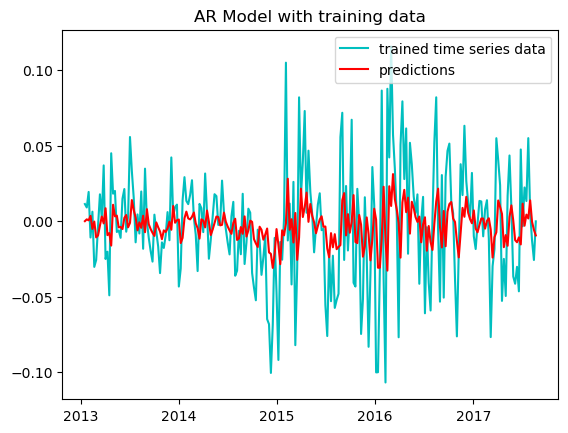

This trained model has RMSE value of 0.03657601785184015


In [33]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

ar_model = AutoReg(train_shifted, lags=1).fit()
predictions = ar_model.predict(start=0, end=len(train_shifted)-1)
predictions.fillna(0, inplace=True)
plt.plot(train_shifted, color='c', label='trained time series data')
plt.plot(predictions, color='red', label='predictions')
plt.legend()
plt.title('AR Model with training data')
plt.show()

rmse = np.sqrt(mean_squared_error(predictions, train_shifted))
print(f'This trained model has RMSE value of {rmse}')

/Users/meriamchoummikh/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/Users/meriamchoummikh/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)
/Users/meriamchoummikh/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  self._init_dates(dates, freq)


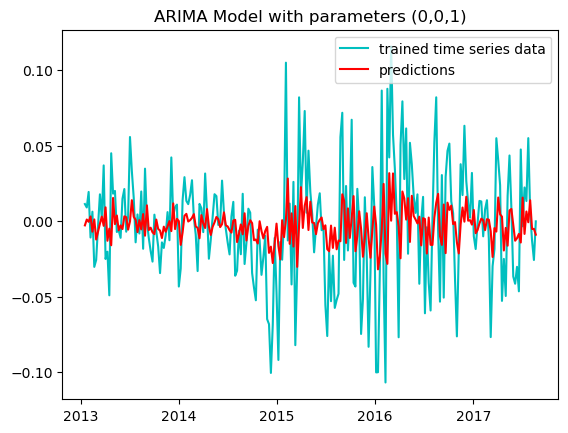

This trained model has RMSE value of 0.036516216744923495


In [34]:
from statsmodels.tsa.arima.model import ARIMA

arima_mod = ARIMA(train_shifted, order=(0, 0, 1)).fit()
predictions_2 = arima_mod.fittedvalues
plt.plot(train_shifted, color='c', label='trained time series data')
plt.plot(predictions_2, color='red', label='predictions')
plt.legend()
plt.title('ARIMA Model with parameters (0,0,1)')

plt.show()

rmse_2 = np.sqrt(mean_squared_error(predictions_2, train_shifted))
print(f'This trained model has RMSE value of {rmse_2}')

In [38]:
predictions

2013-01-15    0.000000
2013-01-22    0.001190
2013-01-29    0.000535
2013-02-05    0.003489
2013-02-12   -0.005171
                ...   
2017-07-25    0.001760
2017-08-01    0.013714
2017-08-08   -0.000393
2017-08-15   -0.005765
2017-08-22   -0.009445
Freq: W-TUE, Length: 241, dtype: float64

In [45]:
predictions_reverse = predictions.cumsum()
predictions_reverse

2013-01-15    0.000000
2013-01-22    0.001190
2013-01-29    0.001726
2013-02-05    0.005215
2013-02-12    0.000044
                ...   
2017-07-25   -0.688135
2017-08-01   -0.674422
2017-08-08   -0.674815
2017-08-15   -0.680580
2017-08-22   -0.690025
Freq: W-TUE, Length: 241, dtype: float64

In [46]:
predictions_ARIMA = np.exp(predictions_log)*train_data.iloc[0] #use exponential function
predictions_ARIMA

date
2013-01-15    94.660000
2013-01-22    94.772759
2013-01-29    94.823494
2013-02-05    95.154904
2013-02-12    94.664121
                ...    
2017-07-25    47.567811
2017-08-01    48.224630
2017-08-08    48.205667
2017-08-15    47.928542
2017-08-22    47.478000
Length: 241, dtype: float64

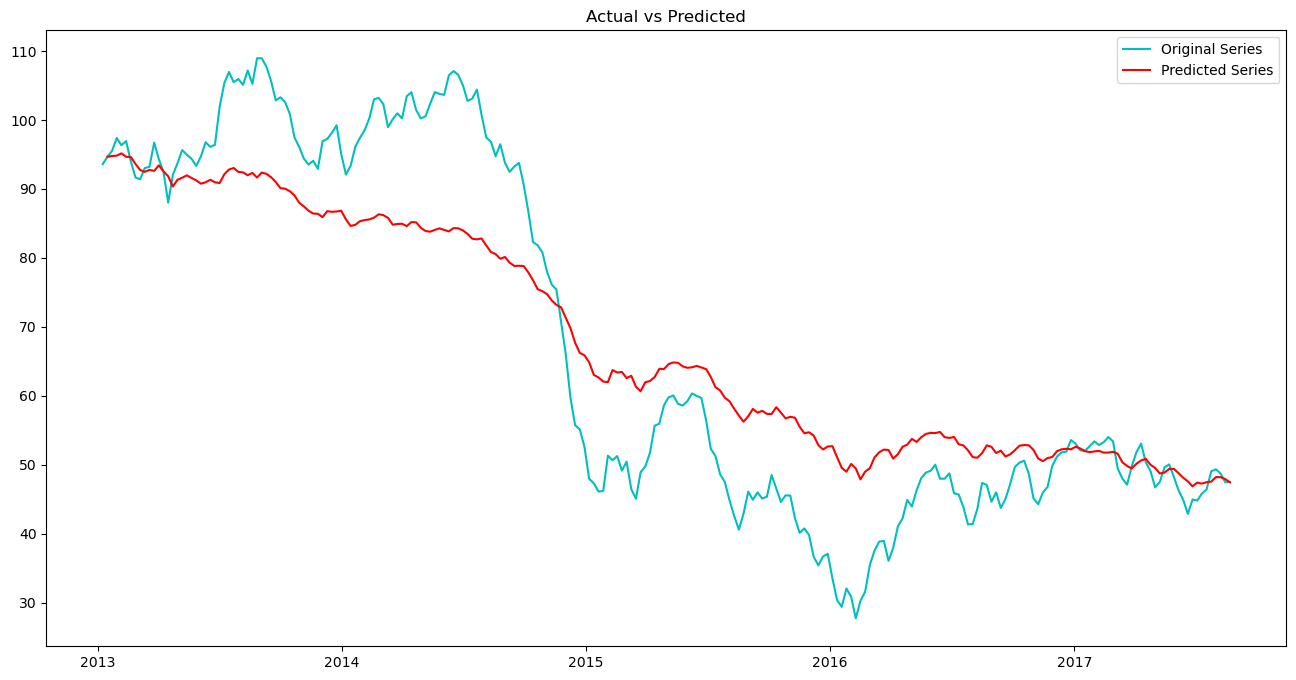

In [47]:
plt.figure(figsize=(16,8))
plt.plot(train_data, color = 'c', label = 'Original Series')  #plot the original train series
plt.plot(predictions_ARIMA, color = 'r', label = 'Predicted Series')  #plot the predictions ARIMA
plt.title('Actual vs Predicted')
plt.legend()
plt.show()